In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [8]:
d_model = 64
name = f"pix2pix_{d_model}"
name = f"test_pix2pix_8_4"
output_dir = f"../output/{name}"

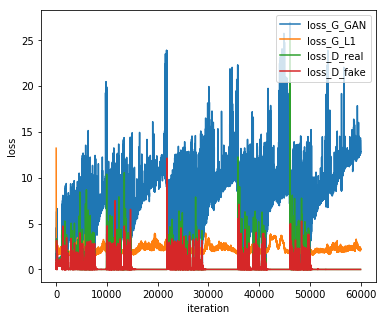

In [7]:
# loss function
fname = f"{output_dir}/loss_log.txt"

df = pd.read_csv(fname, sep=" ", header=0)
header = df.columns

plt.figure(figsize=(6,5))
plt.xlabel("iteration")
plt.ylabel("loss")

epoch = df["#iter"]
key_list = header[3:]
for i, key in enumerate(key_list):
    plt.plot(epoch, df[key], label=key)
plt.legend(loc="upper right")

plt.savefig("loss.png")

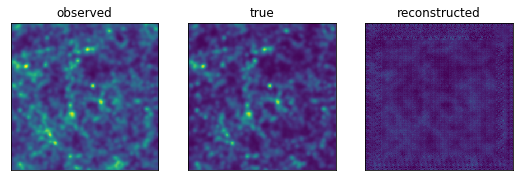

In [10]:
# reproduced mapp
suffix = f"run0_index0"
f_realA = f"../val_data/{suffix}_z1.3_ha.fits"
f_realB = f"../val_data/{suffix}_z2.0_oiii.fits"
f_fakeA = f"{output_dir}/test/gen_{suffix}.fits"

f_list = [ f_realA, f_realB, f_fakeA ]
data = [ fits.open( f )[0].data for f in f_list ]

label_list = ["observed", "true", "reconstructed"]
data = [ data[0]+data[1], data[0], data[2] ]

vmin = 0
vmax = np.max(data[0])

fig = plt.figure(figsize=(9,3))
for i, (d, l) in enumerate(zip(data, label_list)):
    ax = plt.subplot2grid((1,3), (0,i))
    ax.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
    plt.title(l)
    im = plt.imshow(d, interpolation="none", vmin=vmin, vmax=vmax)   
    
plt.savefig("test_image.png")

/usr/local/lib/python3.6/site-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/usr/local/lib/python3.6/site-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/usr/local/lib/python3.6/site-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/site-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/site-packages/numpy/ma/core.py:717: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


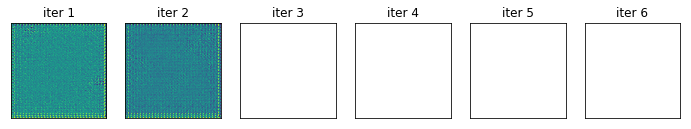

In [9]:
# reproduced mapp
freq = 1
nmap = 6

plt.figure(figsize=(nmap*2, 2))
for i in range(nmap):
    iter = freq * (i+1)
    fname = "{}/iter_{:d}.fits".format(output_dir, iter)
    data = fits.open( fname )[0].data

    ax = plt.subplot2grid((1,nmap), (0,i))
    ax.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
    plt.title("iter {:d}".format(iter))
    im = plt.imshow(data, interpolation="none")    

plt.savefig("training_iter.png")